# Hacking Statistical Significance: Hypothesis Testing with ML Approaches

**Test Statistical Significance in any Context Without Assumptions**

The importance of data analytics is well-known in every field. From business to academics, carrying out proper analysis is the key to reaching cutting-edge results. In this sense, it is crucial to correctly manipulate and extract meaningful insights from the data at our disposal. **Data Analyst/Scientists are responsible to fill the gap between theoretical hypothesis and practical evidence.**

**Providing an analytical answer to all the questions that may raise is an expensive and hard journey.** Translating a question/need in the analytical language it's the first step to carrying out. The goodness of this kind of operation is crucial since it influences the correctness of the final results. During the preliminary phases is it important to understand the analytic goals and point out which are the best data sources, frameworks, and people to engage in order to reach the best outcomes. 

Most of the time **analytically answering questions is made by carrying out a statistical test**. Many statical test work as bellow:
- State a null hypothesis, which is the default option that can describe the world.
- State an alternative and complementary hypothesis.
- Calculate a test statistic (a function of the data) and outline the final results.

**Given the distribution of the test statistic known, the probability to observe any value of the underlying statistic can be easily calculated (p-value)**. If the p-value. If the p-value is smaller than a prefixed (generally 0.01 or 0.05) significance level, the null hypothesis is rejected in favor of the alternative hypothesis. 

There's nothing wrong with the statistical testing, but **there are some hidden pitfalls we should pay attention to:**
- **Strict assumptions on the data.** Most of the time the underlying data must follow normal or known distributions. As we know, real-world phenomena are not normally distributed at all.
- **Limitations to quantities/statistics we are not interest in**. If we want to test something custom or more complicated we may be in troube. 

In this post, we introduce some fancy and simple methods to test hypotheses and extract meaningful insights from the data at our disposal. **We don’t reach conclusions using standard statistical tests but using simulations and permutations.**

## The Data Setup

In order to explain the methodologies, we use a dataset containing records of house sales in King County (USA). The dataset contains house sales prices, sold between May 2014 and May 2015, for King County (including Seattle).

The dataset contains around 20,000 entries or houses sold with different numerical attributes: selling prices, number of bedrooms, number of bathrooms, square footage of the living space, number of floors, latitude/longitude, the building year, and much more. 

In a standard predictive application, it would be interesting to forecast the selling price of the houses given their features. **Here we are not interested in this kind of application. We want to answer some questions by looking at the data in a way that differs from classical statistical testing but that it’s equally efficient (or maybe more flexible).**

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
### IMPORT DATA ###

df = pd.read_csv('kc_house_data.csv')
df['date'] = pd.to_datetime(df['date'])

print(df.shape)
df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Simulation

Let’s imagine being interested to know whether there’s an association between the building years of houses and the selling prices.

Selling prices have a distribution that differs much from a normal one. As we expect a clear linear relationship between prices and building year does not exist.

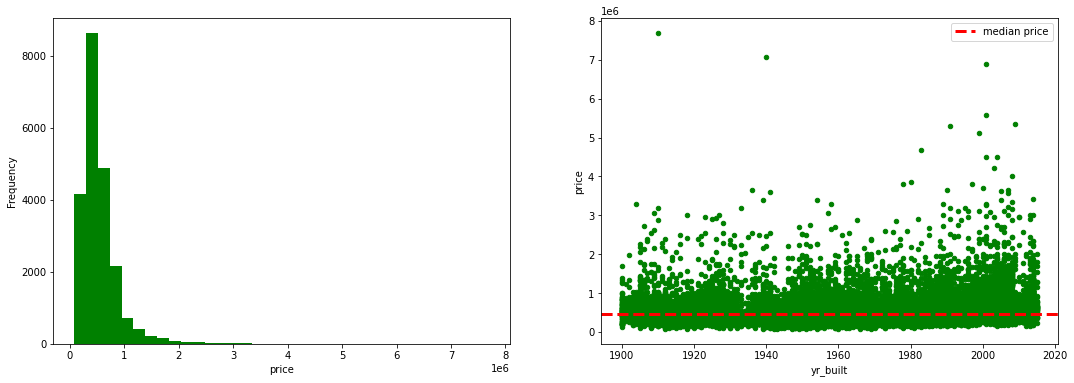

In [4]:
### PLOT DISTRIBUTIONS ###

plt.figure(figsize=(18,6))

plt.subplot((121))
df['price'].plot.hist(bins=35, ax=plt.gca(), color='green')
plt.xlabel('price')

plt.subplot((122))
df.plot.scatter(x='yr_built', y='price', ax=plt.gca(), color='green')
plt.axhline(df['price'].median(), c='red', 
            linestyle='--', linewidth=3, label='median price')
plt.legend()

plt.show()

The median selling price is 45,000$. The houses built in 2015 (the newer ones according to our dataset) have higher median prices. This seems to be reasonable but **it would be interesting to understand if this effect is “due to chance”.**

With “due to chance” we are referring to the fact that we are observing only a sample of the entire population. The data we have at our disposal is limited to only a part of all the house transactions that happened between 2014 and 2015 in King County. There may be more houses built in 2015 that are sold in this period and aren’t recorded in our dataset.

The best we can do in this situation is to take note of the limitations and try to **estimate the real median** of the sold houses built in 2015. We can do this **through simulations**.

As the first step, we compute and store the observed difference between the median selling price of houses built in 2015 and the median selling price on all the data at our disposal. This value (observed difference) represents the difference in prices we can observe and that we want to verify.



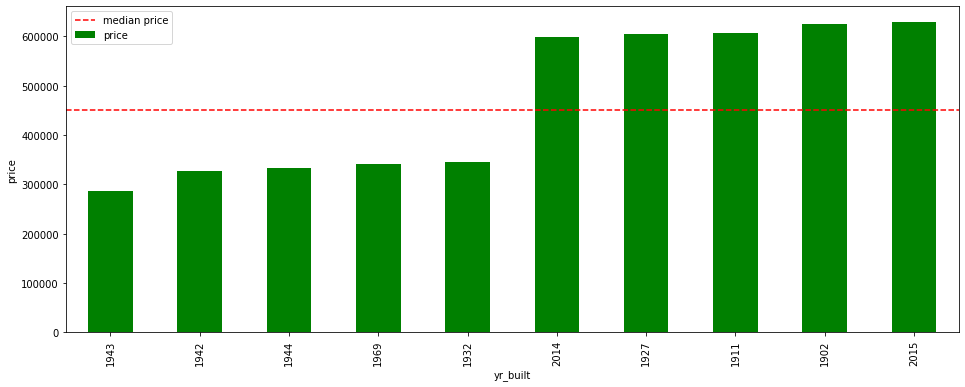

In [5]:
### HIGHEST AND LOWEST MEDIAN SELLING PRICES BY YEAR ###

df.groupby('yr_built')['price'].median().sort_values() \
    .iloc[[0,1,2,3,4,-5,-4,-3,-2,-1]].plot.bar(figsize=(16,6), color='green')
plt.axhline(df['price'].median(), c='red', 
            linestyle='--', label='median price')
plt.legend(); plt.ylabel('price')
plt.show()

In [15]:
### UNIVARIATE SIMULATION FOR A SINGLE YEAR ###

year = 2015

sampling = lambda x,y: x['price'].sample(n=int(y['count']))

y = df[df['yr_built'] == year]['price'].agg(['count','median'])

observed_diff = abs(y['median'] - df['price'].median())

sim_diffs = np.asarray([
    abs(sampling(df,y).median() - df['price'].median())    
    for i in tqdm(range(1_000))
])

p_value = np.mean(sim_diffs >= observed_diff)

100%|██████████| 1000/1000 [00:03<00:00, 268.82it/s]


At this point, we want to check if our observed difference might as well be registered by any random subgroup of sales. We randomly sample groups of the same size as the 2015’s houses and compute the difference between their median prices and the dataset’s median price.

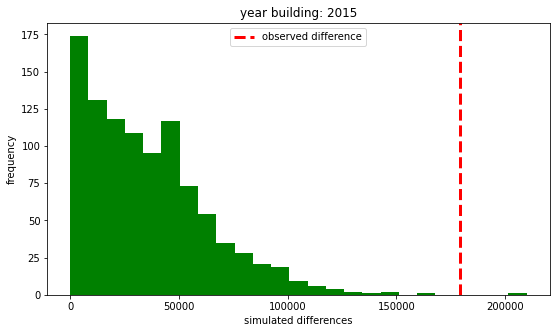

In [16]:
### PLOT UNIVARIATE SIMULATION FOR A SINGLE YEAR ###

plt.figure(figsize=(9,5))
plt.hist(sim_diffs, bins=25, color='green')
plt.axvline(observed_diff, linestyle='--', linewidth=3, c='red', 
            label='observed difference')
plt.title(f'year building: {year}')
plt.legend(); plt.xlabel('simulated differences'); plt.ylabel('frequency')
plt.show()

Lastly, we verify how many times the simulated price differences are higher than our observed difference. This value can be interpreted as the probability of success and represents our estimated p-value.

With a lower p-value, we are more confident to reject the null hypothesis and accept the alternative one. In our case, we are more confident to reject the hypothesis that states there is no price difference between the 2015’s houses and the other ones.

In [18]:
### UNIVARIATE SIMULATION FOR ALL THE YEARS ###

test_diff = {}

for y_b in tqdm(df['yr_built'].unique()):

    y = df[df['yr_built'] == y_b]['price'].agg(['count','median'])

    observed_diff = abs(y['median'] - df['price'].median())

    test_diff[y_b] = np.mean([
        abs(sampling(df,y).median() - df['price'].median()) >= observed_diff
        for i in range(500)
    ])
    
test_diff = pd.Series(test_diff).sort_index()

100%|██████████| 116/116 [03:11<00:00,  1.65s/it]


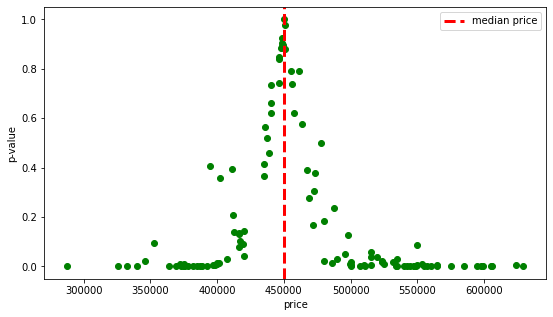

In [19]:
### PLOT UNIVARIATE SIMULATION FOR ALL THE YEAR ###

plt.figure(figsize=(9,5))
plt.scatter(df.groupby('yr_built')['price'].median(), test_diff, c='green')
plt.axvline(df['price'].median(), c='red', 
            linestyle='--', linewidth=3, label='median price')
plt.legend(); plt.xlabel('price'); plt.ylabel('p-value')
plt.show()

According to our needs, we can carry out tests on all the building years of our interest. Below is shown the result of the test for all the years.

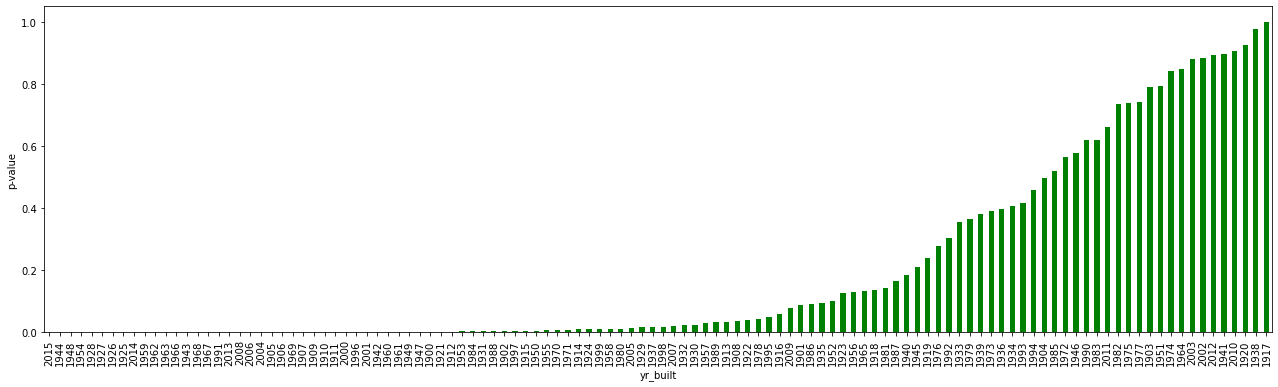

In [20]:
### PLOT UNIVARIATE SIMULATION FOR ALL THE YEAR ###

test_diff.sort_values().plot.bar(figsize=(22,6), color='green')
plt.xlabel('yr_built'); plt.ylabel('p-value')
plt.show()

## Multivariate Simulation

This is an incredible result! **With a few lines of code, we can test and verify any empirical question.** Our study verifies the presence of selling price differences between years of building. Does it mean that houses build in 2015 are different from ones built in the 80s? Not properly, since we have only verified a possible difference in prices. There are a lot of factors which may discriminate houses built in different years. Hopefully, our dataset has many other features that we can use to verify further possible differences.

As before, we want to check if there is a difference between houses built in 2015 and the others. Now we don’t look only at selling prices but we consider all the available features. To operate this kind of multidimensional test efficiently, we fit a binary classification model that discriminates between the 2015’s houses and the others. We register the ROC-AUC as a metric of goodness (observed score).

Then we check if our observed score might as well be registered by any random subgroup of house sales. We randomly sample groups of the same size as the 2015’s houses, fit a binary classifier to discriminate them, and register the obtained ROC-AUC.

In [21]:
### MULTIVARIATE SIMULATION FOR A SINGLE YEAR ###

year = 2015

cv_scoring = lambda x,y: np.mean(cross_val_score(
    RandomForestClassifier(10), 
    x, y, cv=5, scoring='roc_auc', n_jobs=-1, 
    error_score='raise'
))

observed_score = cv_scoring(
    df.drop(['yr_built','date','id'], axis=1), 
    (df['yr_built'] == year).astype(int)
)

sim_scores = np.asarray([
    cv_scoring(
        df.drop(['yr_built','date','id'], axis=1), 
        (df['yr_built'] == year).sample(frac=1).astype(int)
    )
    for i in tqdm(range(1_000))
])

p_value = np.mean(sim_scores >= observed_score)

100%|██████████| 1000/1000 [22:46<00:00,  1.37s/it]


Finally, we can verify, as before, if the observed score is higher than the simulated ones and compute the relative p-value.

In our case, we are more confident to reject the hypothesis that states there is no overall difference between the 2015’s houses and the other ones.

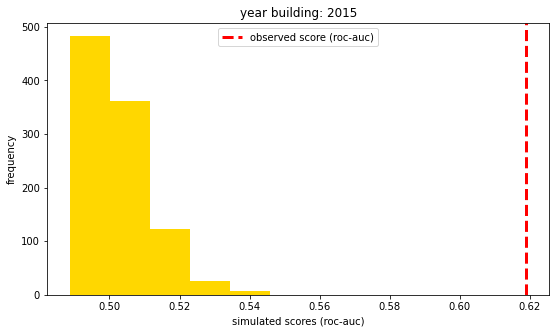

In [22]:
### PLOT MULTIVARIATE SIMULATION FOR A SINGLE YEAR ###

plt.figure(figsize=(9,5))
plt.hist(sim_scores, bins=5, color='gold')
plt.axvline(observed_score, linestyle='--', linewidth=3, c='red', 
            label='observed score (roc-auc)')
plt.title(f'year building: {year}')
plt.legend(); plt.xlabel('simulated scores (roc-auc)'); plt.ylabel('frequency')
plt.show()